In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/bin/../lib/libjpeg.9.dylib

## 1 Load Dataset


In [3]:
df = pd.read_csv('./data/temperature_data.csv')
df.head()

,Day,Temperature
0,1,0.133553
1,2,0.061635
2,3,0.175963
3,4,0.302001
4,5,0.082970


##### Goal of generation:

- perhaps look at first 30 - 60 days of temperature data
- then from pattern, generate for next n days, following timeseries forecasting prediction to generate
- i.e not one-step prediction but range-prediction


In [4]:
df.isna().sum()

Day            0
Temperature    0
dtype: int64

In [5]:
temp_data = df['Temperature'].values
temp_data

array([ 1.33553080e-01,  6.16354178e-02,  1.75963094e-01,  3.02000633e-01,
        8.29696522e-02,  9.42503153e-02,  3.43196993e-01,  2.48034592e-01,
        9.71245621e-02,  2.40968148e-01,  1.20270378e-01,  1.31094645e-01,
        2.34945912e-01, -3.65024057e-02, -8.05929456e-04,  1.62546075e-01,
        1.14401156e-01,  2.99204973e-01,  1.49796025e-01,  9.44382200e-02,
        4.82343917e-01,  2.71251924e-01,  3.20239311e-01,  1.35109122e-01,
        2.60897691e-01,  3.57107878e-01,  2.01936396e-01,  4.12197225e-01,
        2.94285625e-01,  3.44751696e-01,  3.13994096e-01,  6.45431098e-01,
        4.10555534e-01,  2.83263792e-01,  5.39191868e-01,  2.80719734e-01,
        4.77373047e-01,  2.02272890e-01,  2.94068932e-01,  5.02869763e-01,
        5.82644097e-01,  5.16970626e-01,  4.87881950e-01,  4.71975924e-01,
        3.25916274e-01,  4.33496150e-01,  4.75470760e-01,  6.82271400e-01,
        5.96467165e-01,  3.27911161e-01,  6.08909455e-01,  5.23235340e-01,
        4.92111797e-01,  

### 1.1 Data Preprocessing (Time-series)

- specify custom dataset (prep time-series data for training)
- efficient data handling
- compatible with data loaders
- customized preprocessing
  - converting data to tensors

### Usage steps of Custom Dataset class

1. pass temperature data to custom dataset for sequence to be created
2. create dataloader with help of custom dataset
3. feed dataloader to model


In [6]:
T = 30 # sequence length
batch_size = 32 # No. of sequences to be trained per iteration

# Dataset -> handling, managing data in structured way
class TimeSeriesDataset(Dataset): 
    def __init__(self, data, sequence_length): # init custom dataset
        self.data = data # to hold the temperature data
        self.sequence_length = sequence_length # No. time steps to predict next value
    
    # return total No. of sequence that can be created, given no overlap
    # eg: total data = 3, sequence length = 2, then we have 3 - 2 = 1 (1,2) or (2,3)
    # +1 if overlap allowed
    def __len__(self):  
        return len(self.data) - self.sequence_length

    # retrieve specific sequence & corresponding target value
    # i is start idx
    def __getitem__(self, i):
        x = self.data[i: i+self.sequence_length] # sequence data
        y = self.data[i+self.sequence_length] # target
        
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1) # batch_size x sequence_length x input_dim
        y = torch.tensor(y, dtype=torch.float32)

        return x, y


In [7]:
temp_dataset = TimeSeriesDataset(temp_data, T) # T = sequence_length
temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False) # time-series should not shuffle data, order is impt

## 2 Generator / Discriminator Model Init

- the design of the Neural network would be different for time-series data
- time-series data = LSTM


In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim, seq_len): # z_dim is the input dim
        super(Generator, self).__init__() 
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(z_dim, hidden_dim, num_layers=2, batch_first=True) # batch_first means (batchsize x seq_length x hidden_dim)
        self.fc = nn.Sequential( # adding linear layer + activation after can help increase non-linearity and make model capture more complex r/s
                nn.Linear(hidden_dim, output_dim),
                nn.Tanh()
            ) 
    
    def forward(self, x): # pass data through the layers created
        h_0 = torch.zeros(2, x.size(0), self.hidden_dim) # to store all hidden states for LSTM (2 hidden layers, batchsize, hidden_dim)
        c_0 = torch.zeros(2, x.size(0), self.hidden_dim) # to store all cell states for LSTM
        
        lstm_out, _ = self.lstm(x, (h_0, c_0)) # pass x & hidden + cell states thru layers, _ represents the final hidden and cell state output
        out = self.fc(lstm_out)
        return out

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim): 
        super(Discriminator, self).__init__() 
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True) # batch_first means (batchsize x seq_length x hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 1), # output of discriminator is always 1, to tell if synthetic data is real or fake
            nn.Sigmoid()
        )
        
    
    def forward(self, x): # pass data through the layers created
        h_0 = torch.zeros(2, x.size(0), self.hidden_dim) # to store all hidden states for LSTM (2 hidden layers, batchsize, hidden_dim)
        c_0 = torch.zeros(2, x.size(0), self.hidden_dim) # to store all cell states for LSTM
        
        lstm_out, _ = self.lstm(x, (h_0, c_0)) # _ represents the final hidden and cell state output
        out = self.fc(lstm_out[:, -1,:]) # want (all batchsize, last_sequence, all hidden_dim) | evaluate only final_sequence for decision making of realness
        return out

## 3 Model Init and Training


In [9]:
# Parameters
z_dim = 1 # noise vector dim 1 for temperature
output_dim = 1 # predicting single value temperature
hidden_dim = 64 # no. of nodes in hidden layer for LSTM, more nodes = more complex capture
num_epochs = 3000
lr = 0.0001

# Init Models
generator = Generator(z_dim, hidden_dim, output_dim, seq_len=T)
discriminator = Discriminator(z_dim, hidden_dim)

# Define Loss & Optim
criterion = nn.BCEWithLogitsLoss() # combines BCE with Sigmoid, makes it more numerically stable

g_optim = optim.Adam(generator.parameters(), lr=lr)
d_optim = optim.Adam(discriminator.parameters(), lr=lr)


Epoch [0] | D Loss: 1.4514 | G Loss: 0.4693


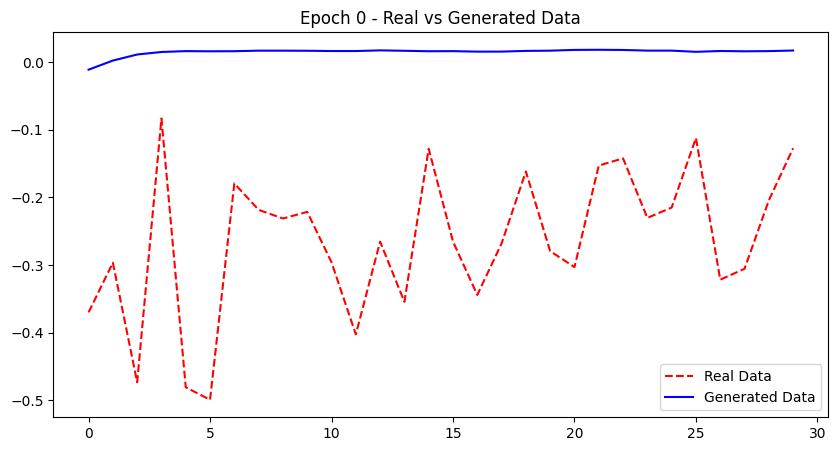

Epoch [300] | D Loss: 1.3865 | G Loss: 0.6844


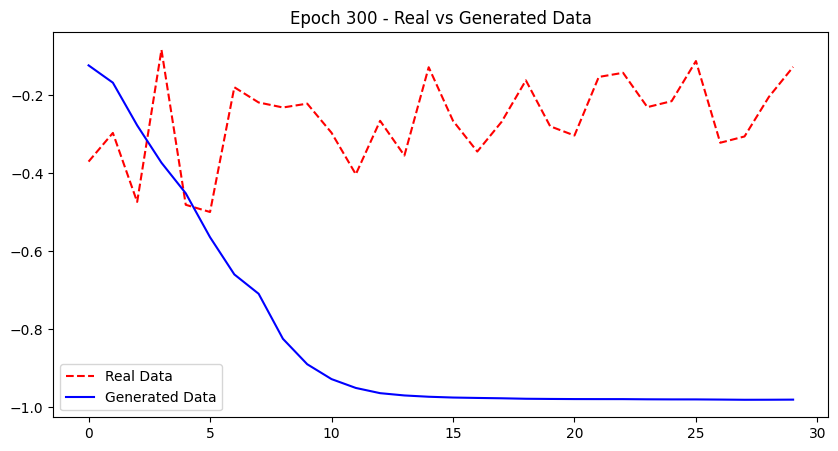

Epoch [600] | D Loss: 1.3865 | G Loss: 0.6807


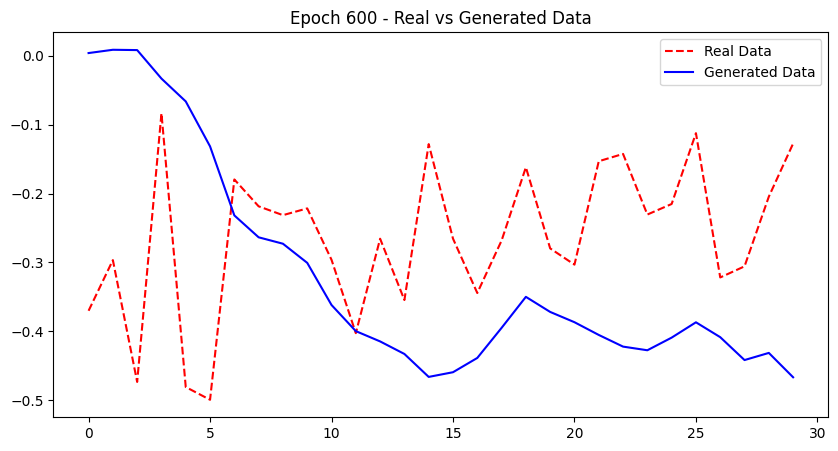

Epoch [900] | D Loss: 1.3819 | G Loss: 0.6708


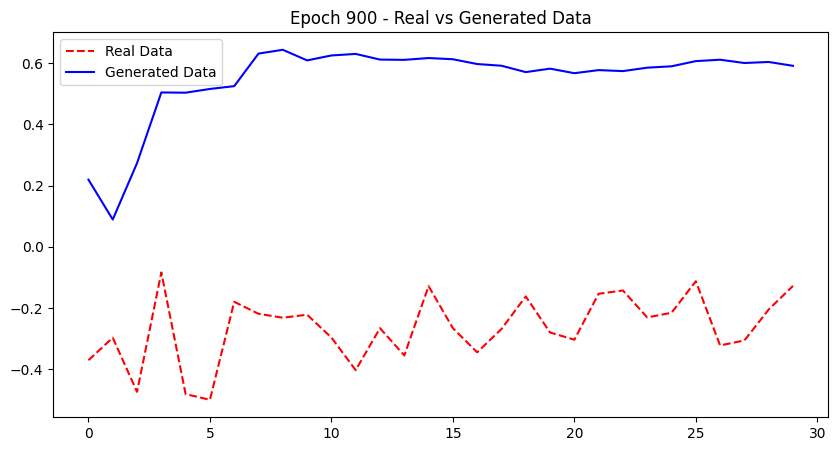

Epoch [1200] | D Loss: 1.3755 | G Loss: 0.6368


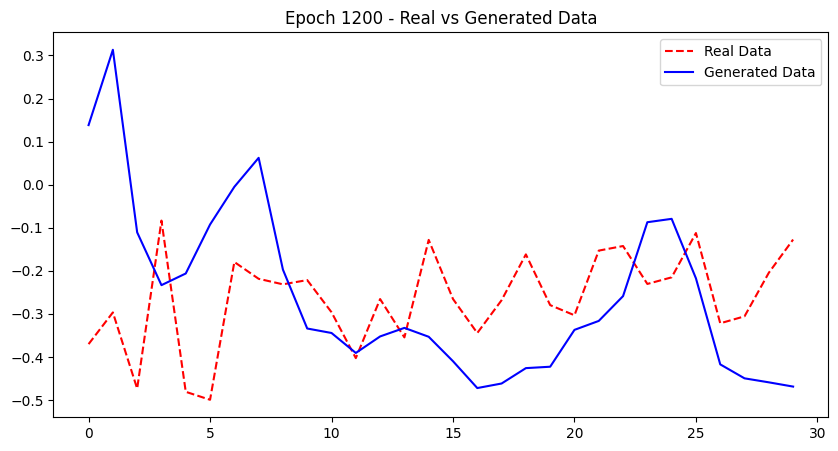

Epoch [1500] | D Loss: 1.3858 | G Loss: 0.6739


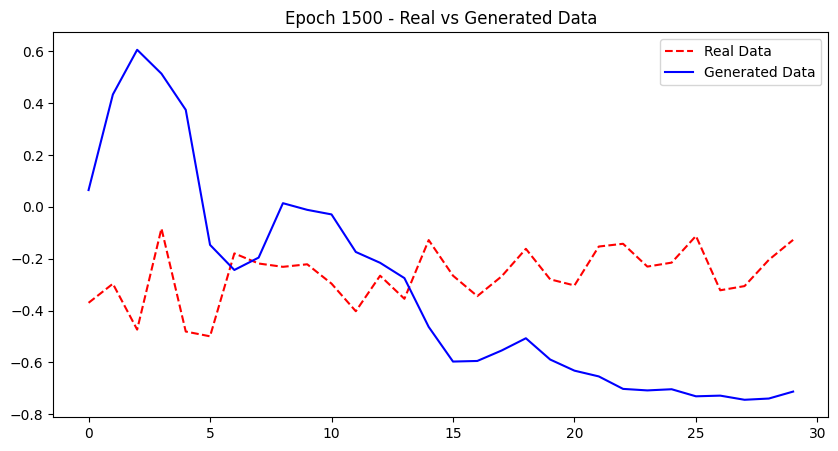

Epoch [1800] | D Loss: 1.3864 | G Loss: 0.6626


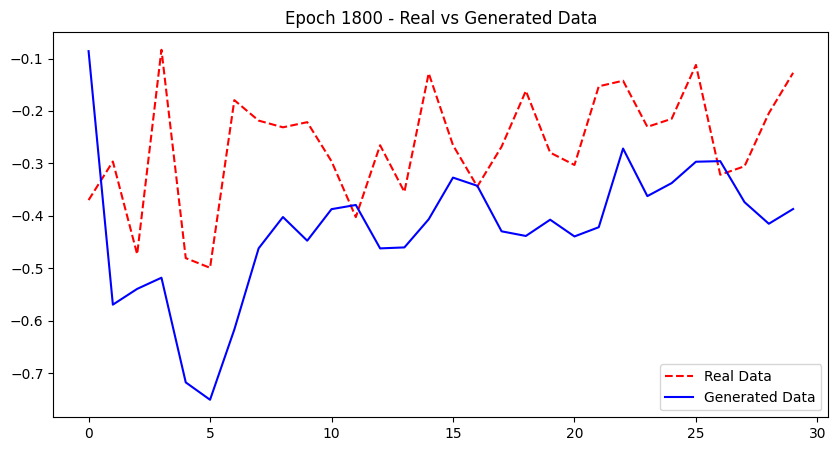

Epoch [2100] | D Loss: 1.3871 | G Loss: 0.6793


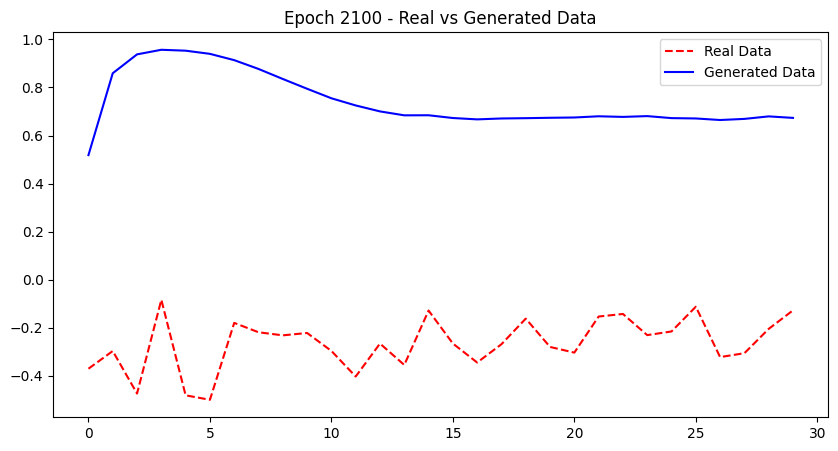

Epoch [2400] | D Loss: 1.3876 | G Loss: 0.6779


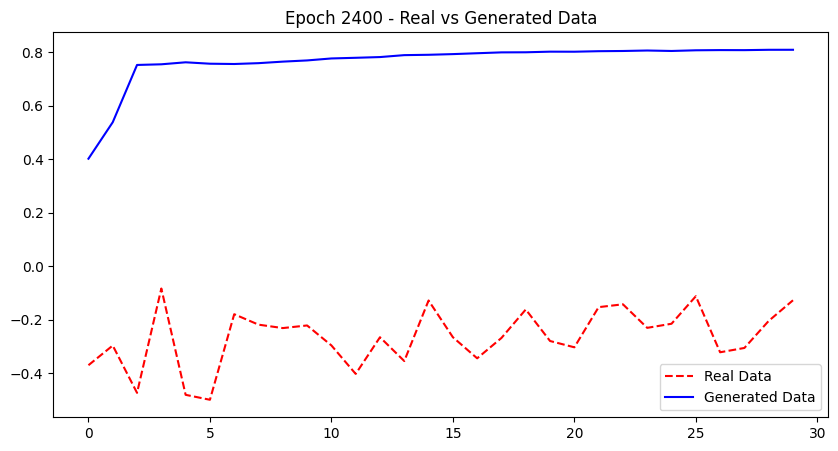

Epoch [2700] | D Loss: 1.3860 | G Loss: 0.6887


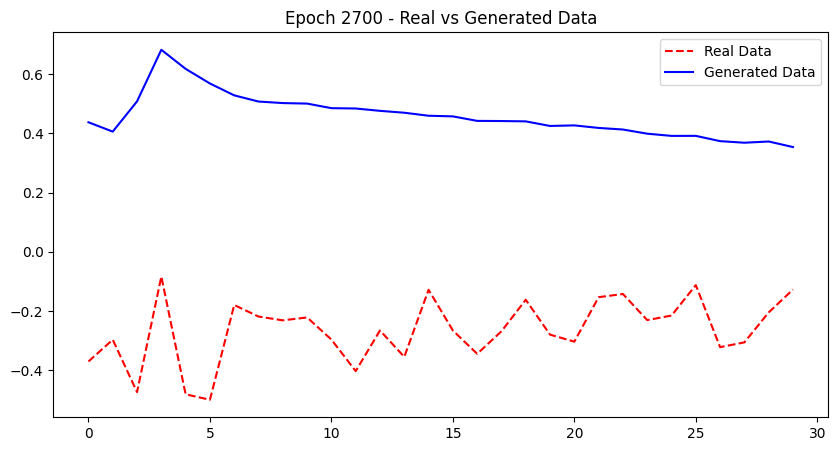

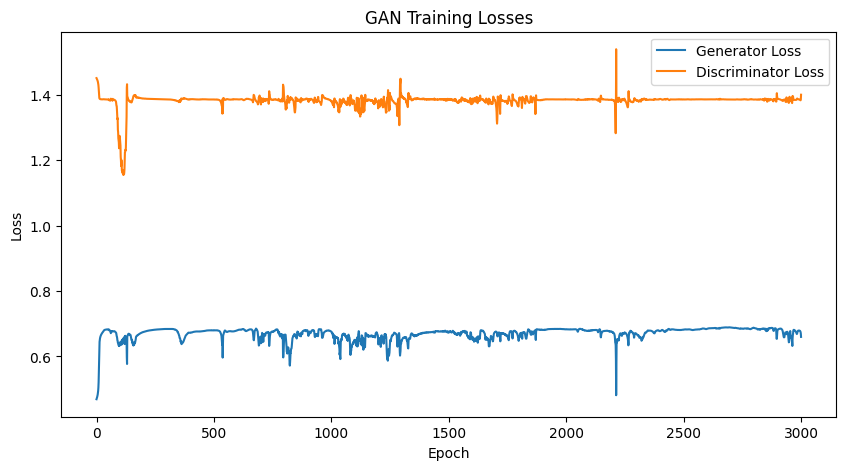

In [10]:
g_losses = []
d_losses = []

# Training loop
for epoch in range(num_epochs):
    
    # Accumulate loss per epoch
    g_loss_epoch = 0
    d_loss_epoch = 0
    
    for real_batch, _ in temp_dataloader: # second element is usually label, but in this 1D temp data, no labels and just placeholder
        batch_size = real_batch.size(0) # [32, 30, 1] - batchsize, sequence length, input dim (temp)
        
        real_labels = torch.ones(batch_size, 1) # real_labels mean probability of 1, create batch_size x 1 col
        fake_labels = torch.zeros(batch_size, 1) # fake_labels means probability of 0
        # tensor([[1], [1]]) for real labels etc.

        # Train Discriminator (want to be the best at identifying fake)
        d_optim.zero_grad() # zero gradient in discriminator to prevent accumulation from previous epoch
        
        real_output = discriminator(real_batch) # train with real data to understand real data
        d_loss_real = criterion(real_output, real_labels) # want real data to be as close as real labels
        
        noise = torch.randn(batch_size, T, z_dim) # T - sequence length
        fake_data = generator(noise).detach() # generate fake data, detach to prevent gradients propagating thru generator
        fake_output = discriminator(fake_data) # take in generated fake data and compare against real data it saw earlier
        d_loss_fake = criterion(fake_output, fake_labels) # want fake data to be as close as fake labels (best detective)
        
        d_loss_total = d_loss_real + d_loss_fake # want to minimize loss
        d_loss_total.backward() # backprop to calc gradient
        d_optim.step() #grad descent to update weights

        # Train Generator (want to generate images as close as real)
        g_optim.zero_grad() # zero grad in generator to prevent accumulation from previous epoch
        
        noise = torch.randn(batch_size, T, z_dim) # create fake data
        fake_data = generator(noise)
        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, real_labels) # compare real with fake and want to minimize difference (make it as real as possible)
        
        g_loss.backward() # backprop to calc grad
        g_optim.step() # grad desc to update weights
        
        # Accumulate loss
        g_loss_epoch += g_loss.item() # getting scalar value for each batch for that epoch
        d_loss_epoch += d_loss_total.item()
    
    g_losses.append(g_loss_epoch / len(temp_dataloader))
    d_losses.append(d_loss_epoch / len(temp_dataloader))
    
    if epoch % 300 == 0:
        print(f"Epoch [{epoch}] | D Loss: {d_loss_epoch / len(temp_dataloader):.4f} | G Loss: {g_loss_epoch / len(temp_dataloader):.4f}")
        with torch.no_grad():
            noise = torch.randn(1, T, z_dim) # generate single sample for visualization
            generated_data = generator(noise).cpu().numpy() # move to cpu for viz
            
            real_data_sample = real_batch[0].cpu().numpy()
            
            plt.figure(figsize=(10, 5))
            plt.plot(real_data_sample, label='Real Data', color='red', linestyle="--")
            plt.plot(generated_data[0], label="Generated Data", color='blue', linestyle='-')
            plt.title(f"Epoch {epoch} - Real vs Generated Data")
            plt.legend()
            plt.show()
            

plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 4 Generate Synthetic Data & Perform Evaluation


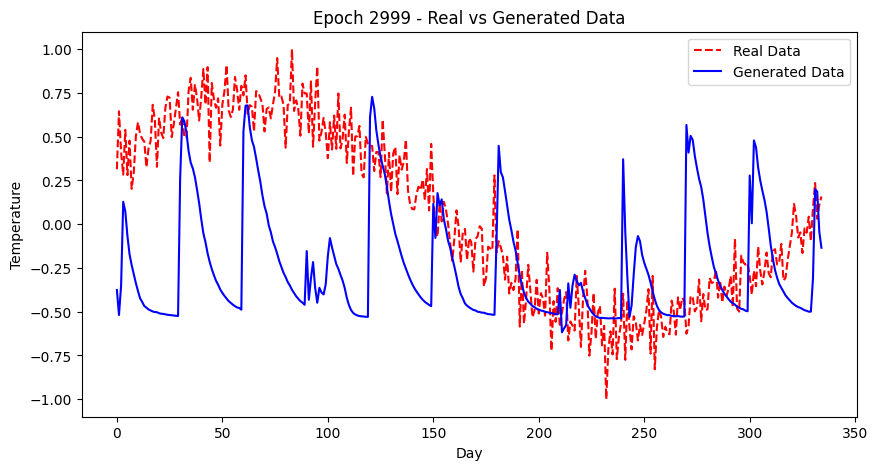

In [30]:
num_sequences = len(temp_data) - T

noise = torch.randn(num_sequences, T, z_dim)
generated_data = generator(noise).detach().numpy().flatten()[:num_sequences] # dont calc gradient

actual_data = temp_data[T:T+num_sequences]

plt.figure(figsize=(10, 5))
plt.plot(actual_data, label='Real Data', color='red', linestyle="--")
plt.plot(range(len(actual_data)), generated_data, label="Generated Data", color='blue', linestyle='-')
plt.title(f"Epoch {epoch} - Real vs Generated Data")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend()
plt.show()


### Conclusion

- due to too few data, data generation might not be ideal
- dont want generated data to be too similar to actual data (want some variation, but have to conform to shape)
